In [1]:
# Notebook header for loading packages

import os
import matplotlib, tikzplotlib
figures_dir = "../../figures/appendix"

from vscworkflows.tools.optics import SolarCell

# Influence of the onset of the absorption spectrum on the SLME

In this notebook, we'll take a quick look a the influence of the onset of the absorption spectrum on the final result for the SLME, as well as the thickness dependence. Of particular interest are the comparison with the shockley-queisser limit, as the small onset can have a significant influence on the SLME as the thickness increases, and as such remove the possibility of crossing the shockley-queisser limit, as we found to be possible in our CuAu-like paper. The basic idea is that because the recombination current is calculated from the combination of the absorptivity and the temperature-dependent blackbody spectrum:

$$
J_0^r = e \pi \int_0^\infty a(E) \Phi_{bb} (E, T) dE
$$

Let's stick to the radiative limit for now, i.e. $J_0=J_0^r$. In case there is an earlier onset of the absorptivity $a(E)$, this will increase the recombination current, which is clear from the integration above. There are several ways to obtain an onset of the absorptivity below the band gap:

* Smearing (or smoothening) of the imaginary part of the dielectric function because of the complex integration used in the Kramer-Kronig transformation in VASP. When performing the Kramers-Kronig transformation, the imaginary part of the dielectric function is overwritten by the smeared version. After this step, there is the following piece of code in the `linear_optics.F` file:<br><br>
```
2244 ! this line overwrites the imaginary part by the original data
2245 ! passed to the subroutine
2246 ! the option is usually selected if the complex shift is small,
2247 ! since in this case the KK transformation above yields inaccurate results
2248 ! for the imaginary part
2249 ! however, this, option can not be used if the input data is already complex
2250 ! values
2251       IF (ABS(CSHIFT) < DELTAE .AND. .NOT. LCOPY) THEN
2252          LWARN=.TRUE.
2253       ENDIF
2254       IF (ABS(CSHIFT) < DELTAE .AND. LCOPY) THEN
2255          EPS_REAL=CMPLX(REAL(EPS_REAL,q),REAL(EPSDD,q))
2256       ENDIF
2257 
2258       EPSDD=EPS_REAL
```
<br>
Simply put, this piece of code once again overwrites the imaginary part of the dielectric function with the original one calculated from the matrix elements 
(line 2255), on two conditions: The CSHIFT value is smaller than the spacing of the energy mesh and there are no significant imaginary parts in the original imaginary part of the dielectric function. This means that in order to make sure that there is no smoothening of the dielectric function, these conditions must be valid.<br><br>
* Using smearing in order to aid the k-point convergence. The influence of this smearing will of course depend on the amount of smearing used.
* Interpolation of the energy grid. If the band gap is in between two energy grid points (which is usually the case), and the distance between the grid point is significantly large, the interpolation of the absorptivity can lead to a small but significant onset below the bandgap.

Let's take a closer look at the various onset-related errors for the SLME calculation.

## CSHIFT

First let's compare the difference between the onset for two CSHIFT choices: 0.1 (highc) and 0.01 (lowc). We'll start by loading the dielectric tensor into a `SolarCell` object:

In [2]:
cuinse2_lowc_n2000 = SolarCell.from_file(os.path.join(os.getcwd(), "data", "lowc_nedos2000.xml"))
cuinse2_highc_n2000 = SolarCell.from_file(os.path.join(os.getcwd(), "data", "highc_nedos2000.xml"))

Next let's plot the onset of the imaginary part of the dielectric function and compare the two:

CSHIFT = 0.01


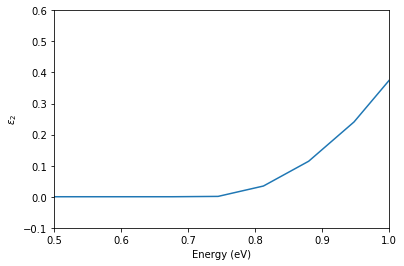

CSHIFT = 0.1


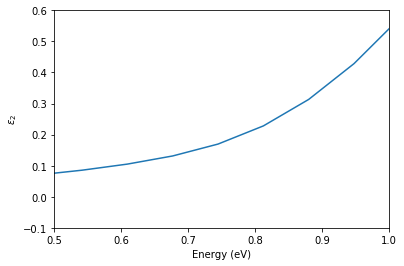

In [3]:
%matplotlib inline
print("CSHIFT = 0.01")
cuinse2_lowc_n2000.dieltensor.plot(part="imag", variable_range=(0.5, 1), diel_range=(-0.1, 0.6))
print("CSHIFT = 0.1")
cuinse2_highc_n2000.dieltensor.plot(part="imag", variable_range=(0.5, 1), diel_range=(-0.1, 0.6))

It's clear that the imaginary part of the highc version has an earlier onset. Let's if the lowc version starts at the band gap:

In [4]:
print("CSHIFT = 0.01, bandgaps: " + str(cuinse2_lowc_n2000.bandgaps))
print("CSHIFT = 0.1, bandgaps: " + str(cuinse2_highc_n2000.bandgaps))

CSHIFT = 0.01, bandgaps: (0.7295000000000003, 0.7295000000000003)
CSHIFT = 0.1, bandgaps: (0.7295000000000003, 0.7295000000000003)


That seems to correspond nicely to the onset of the imaginary part of the dielectric tensor in the figure. Next, let's see the influence on the absorption coefficient:

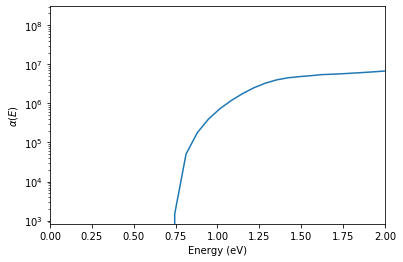

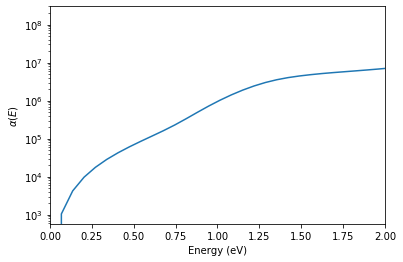

In [5]:
cuinse2_lowc_n2000.dieltensor.plot(part="abs_coeff", variable_range=(0, 2))
cuinse2_highc_n2000.dieltensor.plot(part="abs_coeff", variable_range=(0, 2))

We can see that the effect on the absorption coefficient is pretty dramatic! Now, what happens when we plot the absorptivity, using the formula used in the JARVIS paper?

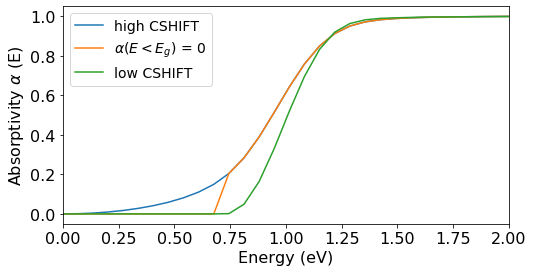

In [6]:
import matplotlib.pyplot as plt
import numpy as np

font = {'size': 16}
plt.rc('font', **font)

# Set the absorptivity to zero for energies below the *direct* band gap
cut_array = np.array([int(el) for el in cuinse2_highc_n2000.dieltensor.energies > cuinse2_highc_n2000.bandgaps[1]])
absorptivity = cut_array * cuinse2_highc_n2000.dieltensor.get_absorptivity(500e-9)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(cuinse2_highc_n2000.dieltensor.energies, 
         cuinse2_highc_n2000.dieltensor.get_absorptivity(500e-9))
ax.plot(cuinse2_highc_n2000.dieltensor.energies, absorptivity)
ax.plot(cuinse2_lowc_n2000.dieltensor.energies, 
         cuinse2_lowc_n2000.dieltensor.get_absorptivity(500e-9))

ax.set_xlabel(("Energy (eV)"))
ax.set_xlim([0, 2])
ax.set_ylabel(r"Absorptivity $\alpha$ (E)")
ax.legend(["high CSHIFT", r"$\alpha$($E<E_g$) = 0", "low CSHIFT"],
          loc="upper left", fontsize=14)

tikzplotlib.save(os.path.join(figures_dir, "onset.tex"))

We can see that the onset of the absorptivity is drastically different and also see the influence of the interpolation. As for most materials the absorptivity at 500 nm quickly goes to 1 for higher energies, the onset has a significant influence when calculating the SLME. To show this, we'll demonstrate the influence on the SLME by plotting the slme versus the thickness, for which we've designed a Solarcell method:

Low CSHIFT (no smearing):


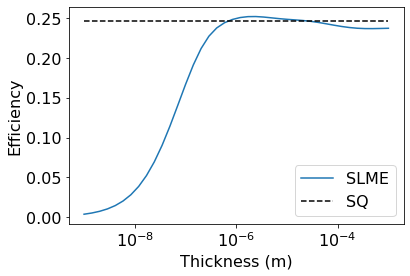

In [7]:
print("Low CSHIFT (no smearing):")
cuinse2_lowc_n2000.plot_slme_vs_thickness(temperature=298.15)

High CSHIFT (smearing):


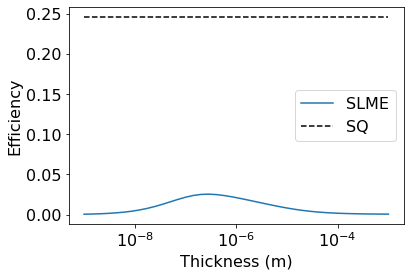

In [8]:
print("High CSHIFT (smearing):")
cuinse2_highc_n2000.plot_slme_vs_thickness(temperature=298.15)

High CSHIFT (smearing) with cutoff:


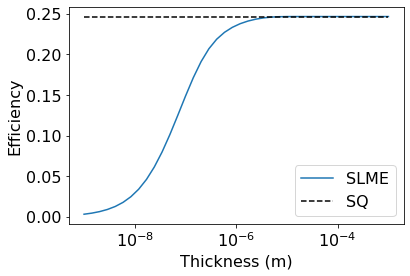

In [9]:
print("High CSHIFT (smearing) with cutoff:")
cuinse2_highc_n2000.plot_slme_vs_thickness(
    temperature=298.15, cut_abs_below_bandgap=True
)

Obviously, the earlier onset of the absorption coefficient severely reduces the SLME for all thicknesses. If we cut off the absorptivity below the bandgap for the `CSHIFT = 0.1` result, there is a drastic change in the SLME for all thicknesses. This makes sense, as the recombination current will be significantly reduced without the smeared onset in the absorptivity. We can also see, however, that the SLME for the low CSHIFT case does not converge neatly to the SQ limit. This is because the band gap is not in the energy grid of the VASP optics calculation, which results in a small earlier onset due to interpolation, as described above. The cutoff example (third figure) doesn't show this behaviour because we set all bandgaps to zero after interpolating on a fine energy mesh. Below we load the results of a calculation of the optical properties with `NEDOS = 6000`, also with `CSHIFT=0.01`:

In [10]:
cuinse2_lowc_n6000 = SolarCell.from_file(os.path.join(os.getcwd(), "data", "lowc_nedos6000.xml"))

/Users/mbercx/miniconda3/envs/vsc/lib/python3.7/site-packages/pymatgen/io/vasp/outputs.py:155: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn('Float overflow (*******) encountered in vasprun')


Nevermind the float overflow, that's in the current-current version of the dielectric function, which I suppose calculated the dielectric function using another method. But so far I've only found strange results for the current-current dielectric function. Let's look at the thickness dependence of the SLME:

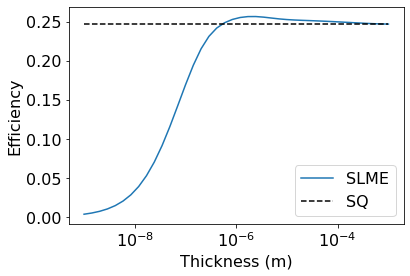

In [11]:
cuinse2_lowc_n6000.plot_slme_vs_thickness(temperature=298.15)

Now we can see that the SLME does nicely converge to the SQ limit as the thickness $\rightarrow\infty$. Finally, let's see what the difference in SLME is between the low `CSHIFT`, and high `CSHIFT` + cutoff case for a thickness of 500 nm:

In [12]:
print("CSHIFT = 0.1: " + str(cuinse2_highc_n2000.slme(temperature=298.15, thickness=5e-7)[0]) + " %")
print("CSHIFT = 0.01: " + str(cuinse2_lowc_n6000.slme(temperature=298.15, thickness=5e-7)[0]) + " %")
print("CSHIFT = 0.1 + cutoff: " + str(cuinse2_highc_n2000.slme(temperature=298.15, thickness=5e-7, cut_abs_below_bandgap=True)[0]) + " %")

CSHIFT = 0.1: 0.02435099908296845 %
CSHIFT = 0.01: 0.24607364506121293 %
CSHIFT = 0.1 + cutoff: 0.22371020824093688 %


As we can see, the difference between the two is still larger than 2%. This will of course depend on the material, so we'd have to make this comparison for several materials in order to get a better idea of the average influence. However, it seems difficult to accept such an error because of the artificial cutoff of the absorptivity. Moreover, introducing Gaussian smearing to the calculation will only increase this difference.

## Crossing the SQ limit

As I'm sure you've noticed, the SLME crosses the SQ limit between $10^{-7}$ m and $10^{-6}$ m for the low CSHIFT case! This effect becomes more pronounced when you increase the temperature to 338.15 K (65°C, which is not an unrealistic temperature for solar cells in operation):

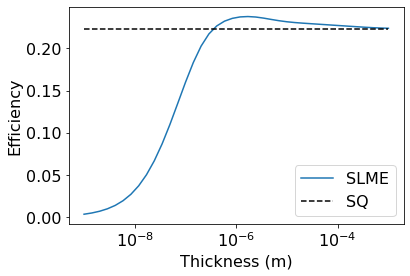

In [13]:
cuinse2_lowc_n6000.plot_slme_vs_thickness(temperature=338.15)

Also note that the efficiency has gone down, which is to be expected, because a higher operating temperature leads to an increased recombination current. This does not occur for the thickness dependent SLME where we cut off the absorptivity below the band gap. We believe this is a consequence of the fact that the resulting absorptivity will quickly start resembling a step function when the thickness is increased. However, if you increase the temperature to 500 K for the high CSHIFT + cutoff case:

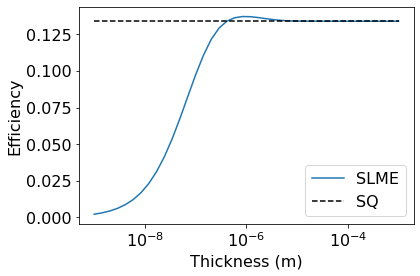

In [16]:
cuinse2_highc_n2000.plot_slme_vs_thickness(temperature=500, cut_abs_below_bandgap=True)

aHA! By increasing the temperature, we once again increase the order of magnitude of the recombination current $J_0$, which means that the relatively low $J_0$ for the SLME compared to the SQ limit allows the SLME to exceed SQ. Sure, 500 K is a bit high for the operating temperature of a solar cell, but that's besides the point. 

By smearing the dielectric function and cutting off the absorptivity, we basically increase the $J_0$ at lower thicknesses, because the absorptivity near the bandgap will be higher compared to the case of `CSHIFT=0.01`. This means that the $J_0$ converge will converge to its SQ value at lower thicknesses, and it was exactly the slow convergence of $J_0$ versus the thickness that caused the SLME to exceed the SQ limit. Besides, the whole smearing + cutoff procedure is rather artificial, and hence is clearly less correct than using the unsmeared dielectric function, in our view.